In [87]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [88]:
from pathlib import Path

import pandas as pd
import torch
from torch import Tensor

_PERSON_INCOME_MAP = {
    'MORTGAGE': 0,
    'RENT': 1,
    'OWN': 2,
    'OTHER': 3
}

_LOAN_NTENT_MAP = {
    'EDUCATION': 0,
    'MEDICAL': 1,
    'VENTURE': 2,
    'PERSONAL': 3,
    'DEBTCONSOLIDATION': 4,
    'HOMEIMPROVEMENT': 5
}

_LOAN_GRADE_MAP = {
    'A': 0,
    'B': 1,
    'C': 2,
    'D': 3,
    'E': 4,
    'F': 5,
    'G': 6
}

_CB_FILE_MAP = {
    'N': 0,
    'Y': 1
}

class LoanDataset(Dataset):
    def __init__(self, data: pd.DataFrame):
        self._data = data

    def __len__(self):
        return len(self._data)

    def __getitem__(self, item: int) -> dict[str, dict[str | Tensor] | Tensor]:
        item = self._data.iloc[item]
        return {
            'target': torch.scalar_tensor(item['loan_status'], dtype=torch.float32),
            'cat_features': {
                'person_home_ownership': torch.scalar_tensor(_PERSON_INCOME_MAP[item['person_home_ownership']], dtype=torch.long),
                'loan_intent': torch.scalar_tensor(_LOAN_NTENT_MAP[item['loan_intent']], dtype=torch.long),
                'loan_grade': torch.scalar_tensor(_LOAN_GRADE_MAP[item['loan_grade']], dtype=torch.long),
                'cb_person_default_on_file': torch.scalar_tensor(_CB_FILE_MAP[item['cb_person_default_on_file']], dtype=torch.long)
            },
            'numeric_features': {
                'person_age': torch.scalar_tensor(-1 if pd.isna(item['person_age']) else (item['person_age'] / 123), dtype=torch.float32),
                'person_income': torch.scalar_tensor(-1 if pd.isna(item['person_income']) else (item['person_income'] / 1200000), dtype=torch.float32),
                'person_emp_length': torch.scalar_tensor(-1 if pd.isna(item['person_emp_length']) else (item['person_emp_length'] / 123), dtype=torch.float32),
                'loan_amnt': torch.scalar_tensor(-1 if pd.isna(item['loan_amnt']) else (item['loan_amnt'] / 35000), dtype=torch.float32),
                'loan_int_rate': torch.scalar_tensor(-1 if pd.isna(item['loan_int_rate']) else (item['loan_int_rate'] / 23.22), dtype=torch.float32),
                'loan_percent_income': torch.scalar_tensor(-1 if pd.isna(item['loan_percent_income']) else (item['loan_percent_income']), dtype=torch.float32),
                'cb_person_cred_hist_length': torch.scalar_tensor(-1 if pd.isna(item['cb_person_cred_hist_length']) else (item['cb_person_cred_hist_length'] / 30), dtype=torch.float32)
            }
        }


class LoanCollator:
    def __call__(self, items: list[dict[str, dict[str | Tensor] | Tensor]]) -> dict[str, dict[str | Tensor] | Tensor]:
        return {
            'target': torch.stack([x['target'] for x in items]),
            'cat_features': {
                'person_home_ownership': torch.stack([x['cat_features']['person_home_ownership'] for x in items]),
                'loan_intent': torch.stack([x['cat_features']['loan_intent'] for x in items]),
                'loan_grade': torch.stack([x['cat_features']['loan_grade'] for x in items]),
                'cb_person_default_on_file': torch.stack([x['cat_features']['cb_person_default_on_file'] for x in items])
            },
            'numeric_features': {
                'person_age': torch.stack([x['numeric_features']['person_age'] for x in items]),
                'person_income': torch.stack([x['numeric_features']['person_income'] for x in items]),
                'person_emp_length': torch.stack([x['numeric_features']['person_emp_length'] for x in items]),
                'loan_amnt': torch.stack([x['numeric_features']['loan_amnt'] for x in items]),
                'loan_int_rate': torch.stack([x['numeric_features']['loan_int_rate'] for x in items]),
                'loan_percent_income': torch.stack([x['numeric_features']['loan_percent_income'] for x in items]),
                'cb_person_cred_hist_length': torch.stack([x['numeric_features']['cb_person_cred_hist_length'] for x in items])
            }
        }


def load_loandata() -> tuple[LoanDataset, LoanDataset]:
    df_train = pd.read_csv('loan_train.csv')
    df_test = pd.read_csv('loan_test.csv')
    return LoanDataset(df_train), LoanDataset(df_test)

# Эксперимент 1. Простая модель

In [89]:
class FirstModel(nn.Module):
    def __init__(self, input_size, hidden_size=32):
        super().__init__()

        self.emb_person_home_ownership = nn.Embedding(4, embedding_dim=hidden_size)
        self.emb_loan_intent = nn.Embedding(6, embedding_dim=hidden_size)
        self.emb_loan_grade = nn.Embedding(7, embedding_dim=hidden_size)
        self.emb_cb_person_default_on_file = nn.Embedding(2, embedding_dim=hidden_size)

        self.numeric_linear = nn.Linear(7, hidden_size)

        self.block = nn.Sequential(
            nn.Linear(hidden_size, hidden_size*4),
            nn.ReLU(),
            nn.Linear(hidden_size*4, hidden_size)
        )

        self.linear_out = nn.Linear(hidden_size, 1)

    def forward(self, cat_features: dict[str, Tensor], numeric_features: dict[str, Tensor]) -> Tensor:
        x_person_home_ownership = self.emb_person_home_ownership(cat_features['person_home_ownership'])
        x_loan_intent = self.emb_loan_intent(cat_features['loan_intent'])
        x_loan_grade = self.emb_loan_grade(cat_features['loan_grade'])
        x_cb_person_default_on_file = self.emb_cb_person_default_on_file(cat_features['cb_person_default_on_file'])

        stacked_numeric = torch.stack([numeric_features['person_age'],
                                       numeric_features['person_income'],
                                       numeric_features['person_emp_length'],
                                       numeric_features['loan_amnt'],
                                       numeric_features['loan_int_rate'],
                                       numeric_features['loan_percent_income'],
                                       numeric_features['cb_person_cred_hist_length']
                                       ], dim=-1)

        x_numeric = self.numeric_linear(stacked_numeric)
        x = x_person_home_ownership + x_loan_intent + x_loan_grade + x_cb_person_default_on_file + x_numeric

        x = self.block(x)
        x = self.linear_out(x)
        return x.squeeze(-1)



In [90]:
def _map_to_device(batch: dict, dev: torch.device) -> dict:
    batch['target'] = batch['target'].to(dev)

    batch['cat_features']['person_home_ownership'] = batch['cat_features']['person_home_ownership'].to(dev)
    batch['cat_features']['loan_intent'] = batch['cat_features']['loan_intent'].to(dev)
    batch['cat_features']['loan_grade'] = batch['cat_features']['loan_grade'].to(dev)
    batch['cat_features']['cb_person_default_on_file'] = batch['cat_features']['cb_person_default_on_file'].to(dev)

    batch['numeric_features']['person_age'] = batch['numeric_features']['person_age'].to(dev)
    batch['numeric_features']['person_income'] = batch['numeric_features']['person_income'].to(dev)
    batch['numeric_features']['person_emp_length'] = batch['numeric_features']['person_emp_length'].to(dev)
    batch['numeric_features']['loan_amnt'] = batch['numeric_features']['loan_amnt'].to(dev)
    batch['numeric_features']['loan_int_rate'] = batch['numeric_features']['loan_int_rate'].to(dev)
    batch['numeric_features']['loan_percent_income'] = batch['numeric_features']['loan_percent_income'].to(dev)
    batch['numeric_features']['cb_person_cred_hist_length'] = batch['numeric_features']['cb_person_cred_hist_length'].to(dev)


In [91]:
# pip install aim

In [92]:
# pip install torchmetrics

In [93]:
train_losses = []
eval_losses = []
train_roc_auc_values = []
eval_roc_auc_values = []

In [94]:
from pathlib import Path

import torch
from aim import Run
from torch.nn import BCEWithLogitsLoss
from torch.optim import SGD
from torch.utils.data import Dataset, DataLoader
from torchmetrics import MeanMetric, AUROC
from tqdm import tqdm

def train(train_dataset, eval_dataset):
    dev = torch.device('cuda:0')
    base_hidden_size = 32
    lr = 0.01
    n_epochs = 10
    batch_size = 32
    seed = 42
    weight_decay = 0.01

    torch.random.manual_seed(seed)

    loss_bce = BCEWithLogitsLoss()

    collator = LoanCollator()
    model = FirstModel(input_size = base_hidden_size, hidden_size=base_hidden_size).to(dev)
    optimizer = SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

    run = Run(experiment='123')
    run["hparams"] = {
        "learning_rate": lr,
        "base_hidden_size": base_hidden_size,
        "batch_size": batch_size,
        'weight_decay': weight_decay
    }

    train_dl = DataLoader(train_dataset, batch_size=batch_size, num_workers=8, collate_fn=collator, pin_memory=True)
    eval_dl = DataLoader(eval_dataset, batch_size=batch_size, num_workers=8, collate_fn=collator, pin_memory=True)

    # train_losses = []
    # eval_losses = []
    # train_roc_auc_values = []
    # eval_roc_auc_values = []

    for i_epoch in tqdm(range(n_epochs)):
        train_loss = MeanMetric().to(dev)
        train_rocauc = AUROC(task='binary').to(dev)

        for i, batch in enumerate(train_dl):
            _map_to_device(batch, dev)

            result = model(cat_features=batch['cat_features'], numeric_features=batch['numeric_features'])
            loss_value = loss_bce(result, batch['target'])
            loss_value.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss.update(loss_value)
            train_rocauc.update(torch.sigmoid(result), batch['target'])

        train_loss_value = train_loss.compute().item()
        train_rocauc_value = train_rocauc.compute().item()
        train_losses.append(train_loss_value)
        train_roc_auc_values.append(train_rocauc_value)
        run.track(train_loss_value, name='loss/train', step=i_epoch)
        run.track(train_rocauc_value, name='roc-auc/train', step=i_epoch)

        eval_loss = MeanMetric().to(dev)
        eval_rocauc = AUROC(task='binary').to(dev)

        model.eval()
        with torch.no_grad():
            for i_eval, batch_eval in enumerate(eval_dl):
                _map_to_device(batch_eval, dev)

                result_eval = model(cat_features=batch_eval['cat_features'], numeric_features=batch_eval['numeric_features'])
                eval_loss_value = loss_bce(result_eval, batch_eval['target'])

                eval_loss.update(eval_loss_value)
                eval_rocauc.update(torch.sigmoid(result_eval), batch_eval['target'])

        eval_loss_value = eval_loss.compute().item()
        eval_rocauc_value = eval_rocauc.compute().item()
        eval_losses.append(eval_loss_value)
        eval_roc_auc_values.append(eval_rocauc_value)
        run.track(eval_loss_value, name='loss/eval', step=i_epoch)
        run.track(eval_rocauc_value, name='roc-auc/eval', step=i_epoch)

        model.train()

        eval_loss = eval_loss.compute().item()
        eval_rocauc = eval_rocauc.compute().item()
        run.track(eval_loss, name='loss/eval', step=i_epoch)
        run.track(eval_rocauc, name='roc-auc/eval', step=i_epoch)


In [95]:
train_ds, test_ds = load_loandata()
train(train_ds, test_ds)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 10/10 [04:15<00:00, 25.51s/it]


In [96]:
# import torch
# print(torch.cuda.is_available())
# print(torch.cuda.device_count())
# print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA GPU detected")

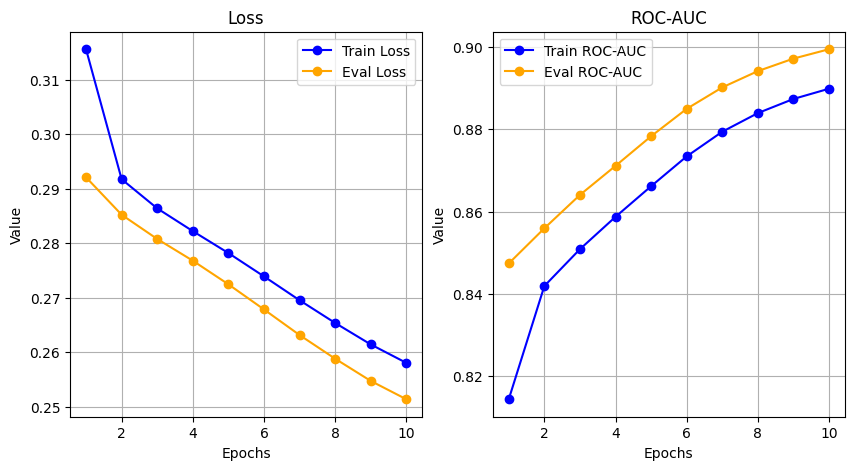

In [104]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', color='blue', marker='o')
axs[0].plot(range(1, len(eval_losses) + 1), eval_losses, label='Eval Loss', color='orange', marker='o')
axs[0].set_title('Loss')

axs[1].plot(range(1, len(train_roc_auc_values) + 1), train_roc_auc_values, label='Train ROC-AUC', color='blue', marker='o')
axs[1].plot(range(1, len(eval_roc_auc_values) + 1), eval_roc_auc_values, label='Eval ROC-AUC', color='orange', marker='o')
axs[1].set_title('ROC-AUC')

for i in range(2):
  axs[i].set_xlabel('Epochs')
  axs[i].set_ylabel('Value')
  axs[i].legend()
  axs[i].grid()

Вывод: С каждой эпохой результаты улучшаются и делать менее 10 не стоит, но и много эпох брать не надо, так как под конец графики изменяются не значительно и при большом колве эпох может произойти переобучение

# Эксперимент 2. Модель побольше

In [ ]:
class SecondModel(nn.Module):
    def __init__(self, input_size, hidden_size=32):
        super().__init__()

        self.emb_person_home_ownership = nn.Embedding(4, embedding_dim=hidden_size)
        self.emb_loan_intent = nn.Embedding(6, embedding_dim=hidden_size)
        self.emb_loan_grade = nn.Embedding(7, embedding_dim=hidden_size)
        self.emb_cb_person_default_on_file = nn.Embedding(2, embedding_dim=hidden_size)

        self.numeric_linear = nn.Linear(7, hidden_size)

        self.block1 = nn.Sequential(
            nn.Linear(hidden_size, hidden_size*4),
            nn.ReLU(),
            nn.Linear(hidden_size*4, hidden_size)
        )
        # self.block2 = nn.Sequential(
        #     nn.Linear(hidden_size, hidden_size*4),
        #     nn.ReLU(),
        #     nn.Linear(hidden_size*4, hidden_size)
        # )
        # self.block3 = nn.Sequential(
        #     nn.Linear(hidden_size, hidden_size*4),
        #     nn.ReLU(),
        #     nn.Linear(hidden_size*4, hidden_size)
        # )

        self.linear_out = nn.Linear(hidden_size, 1)

    def forward(self, cat_features: dict[str, Tensor], numeric_features: dict[str, Tensor]) -> Tensor:
        x_person_home_ownership = self.emb_person_home_ownership(cat_features['person_home_ownership'])
        x_loan_intent = self.emb_loan_intent(cat_features['loan_intent'])
        x_loan_grade = self.emb_loan_grade(cat_features['loan_grade'])
        x_cb_person_default_on_file = self.emb_cb_person_default_on_file(cat_features['cb_person_default_on_file'])

        stacked_numeric = torch.stack([numeric_features['person_age'],
                                       numeric_features['person_income'],
                                       numeric_features['person_emp_length'],
                                       numeric_features['loan_amnt'],
                                       numeric_features['loan_int_rate'],
                                       numeric_features['loan_percent_income'],
                                       numeric_features['cb_person_cred_hist_length']
                                       ], dim=-1)

        x_numeric = self.numeric_linear(stacked_numeric)
        x = x_person_home_ownership + x_loan_intent + x_loan_grade + x_cb_person_default_on_file + x_numeric

        x = self.block1(x)
        x = self.linear_out(x)
        return x.squeeze(-1)

